<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>



In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')



<IPython.core.display.Javascript object>

# Generate `bicorr` from `cced`

Author: Patricia Schuster  
Date: Fall 2016/Winter 2017  
Institution: University of Michigan NERS  
Email: pfschus@umich.edu

# What are we doing today?
Goal: Write the script to produce the bicorrelation plot. Here are the major steps in this work:

1. Read in `cced` files from subfolders (each a different measurement from the same measurement set)
2. Parse the data
3. Store information about detector pair correlations
4. Identify indices of the verified detector and corresponding fission chamber channels
5. Store timing info, detector pair, correlation type
6. Write info out to file
7. Read and write into multiple subfolders
8. Read into another script
9. Produce bicorrelation plot

Note: I found a better way to do the data read-in, which I explore in `bicorr_readin.ipynb`.

I need to parse the `cced` file for each measurement set to produce a distribution of counts vs. $\Delta t_A$ vs. $\Delta t_B$ for two pairs of detectors. 

Select two detectors in the array: A and B. Find events where there are triggers in the fission chamber, A, and B. Calculate the time of the interaction in A and B relative to the fission chamber as:

$$\Delta t_A = t_A - t_{FC}$$
$$\Delta t_B = t_B - t_{FC}$$

The money plot looks like this:

In [1]:
%%html
<img src="fig/plot_sketch.png",width=80%,height=80%>

In [3]:
# Import packages
import os.path
import time
import numpy as np
np.set_printoptions(threshold=np.nan) # print entire matrices
import sys
import inspect
import matplotlib.pyplot as plt

I am going to construct a new script called `bicorr.py`, so set up some code to import and refresh `bicorr.py` for when the time comes. I keep `bicorr.py` in a separate folder called `scripts` where I version control everything. 

First I need to add the folder that contains `bicorr.py` to my system path for this current python session. I wrote a tutorial with more detailed instructions on how to do this here: <https://github.com/pfschus/python-tutorial-file-manipulation/blob/master/python_access_other_folders.ipynb>

In [4]:
sys.path.append('../scripts/')
import bicorr as bicorr

If I make modifications to my `bicorr.py` scripts while running this Jupyter notebook and I want to refresh all the functions, run the following:

In [5]:
%load_ext autoreload
%autoreload 2

# Step 1: Read in cced files from subfolders

## Download part of the `cced1` file to my local machine

I need to download part of the `cced1` file.

To copy part of the `cced1` file into another file, run the following command:

`head -n 1000 cced1 > cced1_part`

This copies the first 1000 lines to a new file called `cced1_part`. I'm going to do that, but for 10,000 lines so I have a smaller file to work with while I write the `bicorr` script.

The contents of the `cced` file looks like:

```
1    7 2 60.43050003051757812500    1.65172    0.20165
1    40 1 -237.56460189819335937500    0.36266    0.03698
2    0 2 56.02870178222656250000    1.00000    0.37657
2    32 2 55.86729812622070312500    1.00000    0.38003
2    33 2 76.49300003051757812500    0.17479    0.03698
3    24 2 58.41870117187500000000    0.90767    0.12300
3    31 2 68.34080123901367187500    0.25033    0.04415
4    10 1 60.55670166015625000000    6.73639    0.82892
4    15 2 69.21060180664062500000    3.84989    0.48209
5    1 1 58.71749877929687500000    1.83345    0.16218
5    12 2 -7.76129913330078125000    0.25288    0.03376
6    4 2 57.22999954223632812500    0.44034    0.05057
6    6 2 10.50279998779296875000    0.27631    0.03217
7    32 2 55.97380065917968750000    1.00000    0.47541
7    44 2 67.53409957885742187500    0.42906    0.06017
8    17 2 56.86849975585937500000    0.08842    0.03812
8    27 2 55.96139907836914062500    1.63040    0.19290
8    30 2 106.28549957275390625000    3.32284    0.41720
9    41 2 56.37910079956054687500    0.28385    0.04117
9    42 1 57.03319931030273437500    1.57115    0.22264
10    22 2 58.14680099487304687500    0.84705    0.13257
10    28 2 325.81359863281250000000    0.42242    0.06293
11    0 2 52.17919921875000000000    1.00000    0.34562
11    14 1 64.22990036010742187500    0.25867    0.04041
12    16 2 56.74929809570312500000    1.00000    0.44734
12    24 1 128.21559906005859375000    1.11157    0.13403
13    37 2 59.00970077514648437500    1.79579    0.24159
13    47 2 58.27090072631835937500    0.86533    0.09690
14    32 2 55.12779998779296875000    1.00000    0.38950
14    46 2 64.88420104980468750000    1.73512    0.20411
```
Where the columns are:

* 1) event number: `evnum`
* 2) channel number `chnum`
* 3) particle (1=n, 2=g) `part`
* 4) time, $ns$ `time`
* 5) PSD total integral `totint`
* 6) pulse height `height`


## Open the `cced` file
Use a simple `open` command, and tell Python to open it read only with option `r`.

In [7]:
cleanFile = open('../datar/cced1_part','r')

In [8]:
print(cleanFile)

<_io.TextIOWrapper name='../datar/cced1_part' mode='r' encoding='cp1252'>


## Access `cced` files in subfolders
When I do the analysis on the cluster, I will have to get data out of subfolders separated by measurement. How do I do that? I created a new folder `1` on my local machine with `cced1_part` in it, but then I renamed it to `cced1` to match the filenames that I will encounter on the cluster. Try accessing it.

In [14]:
cleanFile = open("../datar/1/cced1",'r')
print(cleanFile)
cleanFile.close()

<_io.TextIOWrapper name='../datar/1/cced1' mode='r' encoding='cp1252'>


## Access `cced` files in other locations

In addition to being in numbered subfolders, I may want to run the analysis from a different directory completely. How can I specify a different `root_path` using a relative folder location?

In [48]:
root_path = '../datar'
folder = 1

In [49]:
os.path.join(root_path + '/' + str(folder))

'../datar1'

In [44]:
os.listdir(root_path + '/' + str(folder))

['cced1']

Set a default `root_path == None`

In [51]:
root_path = None
if root_path == None: root_path = os.getcwd()
folder = 1

In [52]:
os.path.join(root_path + '/' + str(folder))

'C:\\Users\\pfschus\\Box Sync\\Projects\\fnpc\\methods/1'

## Read data from the `cced` file: Attempt 1, `for line in cleanFile:`

Use the method that Matthew used in his script `crossCorr_v4.py` which also parses the `cced` file. Read in the `cced` file and look at its contents. 

This strategy uses an iterator to go line-by-line. The trouble here is that you can't go back in time to previous lines, so I will have to store the event information from every line even if I don't know whether that event is a bicorrelation event. Also, there is no way to tell the iterator to only parse a few lines, or a set range of lines. It will always parse the entire file.

In [13]:
os.listdir('../datar/1')

['cced1_part']

In [15]:
cleanFile = open("../datar/1/cced1",'r')
cleanFile.seek(0,0) # Go back to the beginning of the file (if you have been trying other things the current position may be later)

# What does the file look like?
for line in cleanFile:
    holder = line.split()
    if int(holder[0]) < 20: # Only look at first 20 events
        print(holder)
    
cleanFile.close()

['1', '7', '2', '60.43050003051757812500', '1.65172', '0.20165']
['1', '40', '1', '-237.56460189819335937500', '0.36266', '0.03698']
['2', '0', '2', '56.02870178222656250000', '1.00000', '0.37657']
['2', '32', '2', '55.86729812622070312500', '1.00000', '0.38003']
['2', '33', '2', '76.49300003051757812500', '0.17479', '0.03698']
['3', '24', '2', '58.41870117187500000000', '0.90767', '0.12300']
['3', '31', '2', '68.34080123901367187500', '0.25033', '0.04415']
['4', '10', '1', '60.55670166015625000000', '6.73639', '0.82892']
['4', '15', '2', '69.21060180664062500000', '3.84989', '0.48209']
['5', '1', '1', '58.71749877929687500000', '1.83345', '0.16218']
['5', '12', '2', '-7.76129913330078125000', '0.25288', '0.03376']
['6', '4', '2', '57.22999954223632812500', '0.44034', '0.05057']
['6', '6', '2', '10.50279998779296875000', '0.27631', '0.03217']
['7', '32', '2', '55.97380065917968750000', '1.00000', '0.47541']
['7', '44', '2', '67.53409957885742187500', '0.42906', '0.06017']
['8', '17', '

## Read data from the `cced` file: Attempt 2, `np.genfromtxt`

Instead of reading the `cced` file line by line using an iterator, pull in matches of the `cced` file using the numpy function `np.genfromtxt`. Documentation is here: <https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html>

This function offers the capability of specifying the `dtype`, which is the data type for each value along a row. Follow Matthew's method with `ccedType` in his script.

In [16]:
# Set up formatting for pulling out data (copy from Matthew)
ccedType = np.dtype([('event', np.int32), ('detector', np.int8), ('particle_type', np.int8), ('time', np.float64), ('integral', np.float32), ('height', np.float32)])

# Try reading in the entire file at once
# In this case, I don't need to open the file using open() 
data = np.genfromtxt("../datar/1/cced1",dtype=ccedType)
print(data[0:40])

[(1, 7, 2, 60.43050003051758, 1.6517200469970703, 0.2016499936580658)
 (1, 40, 1, -237.56460189819336, 0.3626599907875061, 0.036979999393224716)
 (2, 0, 2, 56.02870178222656, 1.0, 0.3765699863433838)
 (2, 32, 2, 55.8672981262207, 1.0, 0.3800300061702728)
 (2, 33, 2, 76.49300003051758, 0.17478999495506287, 0.036979999393224716)
 (3, 24, 2, 58.418701171875, 0.9076700210571289, 0.12300000339746475)
 (3, 31, 2, 68.34080123901367, 0.25033000111579895, 0.04414999857544899)
 (4, 10, 1, 60.55670166015625, 6.736390113830566, 0.8289200067520142)
 (4, 15, 2, 69.21060180664062, 3.8498899936676025, 0.4820899963378906)
 (5, 1, 1, 58.717498779296875, 1.8334499597549438, 0.16218000650405884)
 (5, 12, 2, -7.761299133300781, 0.2528800070285797, 0.03376000002026558)
 (6, 4, 2, 57.22999954223633, 0.4403400123119354, 0.05056999996304512)
 (6, 6, 2, 10.502799987792969, 0.276309996843338, 0.03217000141739845)
 (7, 32, 2, 55.97380065917969, 1.0, 0.47541001439094543)
 (7, 44, 2, 67.53409957885742, 0.4290600121

Actually, in this case, I don't even have to open the `cced` file before reading it. I can just specify the filename here. So that simplifies things. 

I don't need this now, but I'm wondering whether it is possible to read in certain parts of the data, or can I only ever read the entire thing from start to finish? I should be able to use the option `skip_header` and `skip_footer`, the number of lines to skip at the beginning and end of the file. The command for this is:

    data = np.genfromtxt("cced1_part",dtype=ccedType, skip_header=3, skip_footer=3)
    
I won't run it here because I don't want to overwrite the `data` matrix I already read in.

This looks like a promising route, and better than the `for line in ccedFile` iterator technique. Go with this.

# Step 2: Parse the data for event information

Now that I have the `data` matrix, pull out event information. The `ccedType` specifies what all of the columns look like. As a reminder, the column names are:

* `event`
* `detector`
* `particle_type`
* `time`
* `integral`
* `height`

## Event indexing / how to access specific data
Play around with the indexing for a while to understand how to access certain information.

In [17]:
# Print all values for the first interaction
print('event',        data[0]['event'])
print('detector',     data[0]['detector'])
print('particle_type',data[0]['particle_type'])
print('time',         data[0]['time'])
print('integral',     data[0]['integral'])
print('height',       data[0]['height'])
print(                data[0])

event 1
detector 7
particle_type 2
time 60.4305000305
integral 1.65172
height 0.20165
(1, 7, 2, 60.43050003051758, 1.6517200469970703, 0.2016499936580658)


In [18]:
# Print all values for the first five interactions
print(data[0:5])

[(1, 7, 2, 60.43050003051758, 1.6517200469970703, 0.2016499936580658)
 (1, 40, 1, -237.56460189819336, 0.3626599907875061, 0.036979999393224716)
 (2, 0, 2, 56.02870178222656, 1.0, 0.3765699863433838)
 (2, 32, 2, 55.8672981262207, 1.0, 0.3800300061702728)
 (2, 33, 2, 76.49300003051758, 0.17478999495506287, 0.036979999393224716)]


In [19]:
# Print event numbers for event numbers less than 3
indices = np.argwhere(data[:]['event']<3)
print(indices)
print(data[indices]['event'])

[[0]
 [1]
 [2]
 [3]
 [4]]
[[1]
 [1]
 [2]
 [2]
 [2]]


## Iterate through `data` and identify when the event number advances

I need to go through the events and find bicorrelation events. In that case there would be at least two detector interactions, and their corresponding fission chamber channels, in a single event. First set up a way to look at all interactions within a history.

Use an iteractor to go through one by one. According to stackoverflow, it is the most efficient way to go line by line through a giant matrix. Unlike with the read-in method `for line in cleanFile`, all of the data is still stored in `data` so the iterator just goes through the events and prompts when to look at `data`.

First set up the framework for iterating through the `data` matrix. Use the python function `enumerate` to loop through the event numbers. If I set it up using the following syntax, python will keep track of the line number `l` and event number `e` together at once:

`for l, e in enumerate(data[:]['event']):`

For now just run through the first 20 lines.

In [20]:
# l is the line number of the current line, starting at 0.
# e is the event number of the current line, starting at 1

# eventNum is the current event number, extending from lines i to j.
eventNum = data[0]['event']; # Start with the first event in the data chunk.
                             # If reading entire file, this is 1. 
                             # If reading a chunk, this may be higher.
i = 0;                       # First line number of first event is always 0

# This is a clever way of keeping track what line you're on. Enumerate through the event numbers, `e`, and python also keeps track of the line number `l`.
for l, e in enumerate(data[:20]['event']):
    print("Reading line: ",l,"; event: ",e)
    
    if e == eventNum: # Still on the same event
        pass          # Don't do anything.... but hold this here in case I want to add something
    
    if e != eventNum: # Store info from currentEvent, move onto next event.
        j = l         # The last index of eventNum is the previous line
        print("The line after event ", eventNum, "is ", j)      # Event number advances
        print("New event number is e=", e)
        
        # This is where all of the event information will be pulled out.
        
        eventNum = e  # Move on to next event
        i = l         # Current line is the first line for next event

Reading line:  0 ; event:  1
Reading line:  1 ; event:  1
Reading line:  2 ; event:  2
The line after event  1 is  2
New event number is e= 2
Reading line:  3 ; event:  2
Reading line:  4 ; event:  2
Reading line:  5 ; event:  3
The line after event  2 is  5
New event number is e= 3
Reading line:  6 ; event:  3
Reading line:  7 ; event:  4
The line after event  3 is  7
New event number is e= 4
Reading line:  8 ; event:  4
Reading line:  9 ; event:  5
The line after event  4 is  9
New event number is e= 5
Reading line:  10 ; event:  5
Reading line:  11 ; event:  6
The line after event  5 is  11
New event number is e= 6
Reading line:  12 ; event:  6
Reading line:  13 ; event:  7
The line after event  6 is  13
New event number is e= 7
Reading line:  14 ; event:  7
Reading line:  15 ; event:  8
The line after event  7 is  15
New event number is e= 8
Reading line:  16 ; event:  8
Reading line:  17 ; event:  8
Reading line:  18 ; event:  9
The line after event  8 is  18
New event number is e

The rest of this analysis is not going to look as beautiful because I am essentially going to copy that last chunk of code and build in new capabilities over and over again. So be ready for a lot of repetition and print statements. 

# Step 3: Store information about detector pair correlations

## Set up detector channel information

Our detector system has 48 channels, three of which are fission chamber channels (0, 16, and 32). Set up lists of the correct detector channel numbers.

Use the function `bicorr.build_ch_lists()`.

In [24]:
help(bicorr.build_ch_lists)

Help on function build_ch_lists in module bicorr:

build_ch_lists(print_flag=False)
    Generate and return lists of the channel numbers that correspond to the fission chamber and detector channels. This is built for the Chi-Nu array measurements. If the detector array changes, we need to modify this function.
    
    Note: In the Chi-Nu array, the fission chamber channels correspond to detector channels as follows:
      - fc 0 det 1-15
      - fc 16 det 17-31
      - fc 32 det 33-47
      
    Run with: chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists()
    
    Parameters
    ----------
    print_flag : bool, optional
        Print the values of all vectors?
    
    Returns
    -------
    chList : ndarray
        All channels measurements
    fcList : ndarray
        Fission chamber channels
    detList : ndarray
        Detector channels
    num_dets : int
        Number of detector channels
    num_det_pairs : int
        Number of pairs of detectors



In [53]:
chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists(print_flag = True)

Fission chamber channels: [ 0 16 32]
Detector channels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Number of detectors: 45
Number of detector pairs: 990


## Identify whether the current event is a bicorrelation event

Each of the following target tasks will be indicated in the code below by including (TARGET #) in the comments.

* First look to see if there are at least three interactions based on the initial and final line numbers for the current event, `i` and `j`. (TARGET 1)
* Look to see whether two detector channels had interactions (TARGET 2)
* Look to see whether the corresponding fission chamber channels had interactions (TARGET 3)

In [54]:
# l is the line number of the current line, starting at 0.
# e is the event number of the current line, starting at 1

# eventNum is the current event number, extending from lines i to j.
eventNum = data[0]['event']; # Start with the first event in the data chunk.
                             # If reading entire file, this is 1. 
                             # If reading a chunk, this may be higher.
i = 0;                       # First line number of first event is always 0

I am going to make use of some boolean logic here. If `chs_bool` is a boolean array, then taking the `sum` of `chs_bool` will count the number of `True` instances. 

In [55]:
# This is a clever way of keeping track of what line you're on. Enumerate through the event numbers, `e`, and python also keeps track of the line number `l`.
for l, e in enumerate(data[:40]['event']):    
    if e == eventNum: # Still on the same event
        pass          # Hold for later
    
    if e != eventNum: # Store info from current event, move onto next event.
        j = l       # The last index of eventNum is the previous line
        n_ints = j-i # Number interactions in current event
        
        if n_ints > 2: # If there are more than 2 interactions in the event (TARGET 1)
            ccedEvent = data[i:j][:] # Pull out the data from this event
            print("ccedEvent:")
            print(ccedEvent)
            
            chs_present = ccedEvent[:]['detector'] # What channels triggered?
            print("chs_present",chs_present)
            
            chs_bool = np.in1d(chs_present,detList) # True = detector, False = fission chamber
            print("chs_bool",chs_bool)
            
            if sum(chs_bool)>1: # If at least two interactions were detectors / two or more Trues (TARGET 2)
                # Did the corresponding fc's trigger?
                dets_present = chs_present[chs_bool] # Which det channels triggered?
                print(dets_present)
            
                fc_corr = (16*np.floor(dets_present/16)).astype(int) # Corresponding fission chambers for each det channel
                print("fc_corr",fc_corr)

                fc_bool = np.in1d(fc_corr,chs_present) # Did the corresponding fission chamber trigger? (TARGET 3)
                print("fc_bool",fc_bool)
                
                if sum(fc_bool)>1: # If at least two detectors had corresponding fc triggers
                    # Only keep events where det and corresponding fc triggered
                    print("bicorrelation event!")
                    print(dets_present[fc_bool])
                    print(fc_corr[fc_bool])

        eventNum = e  # Move on to next event
        i = l         # Current line is the first line for next event

ccedEvent:
[(2, 0, 2, 56.02870178222656, 1.0, 0.3765699863433838)
 (2, 32, 2, 55.8672981262207, 1.0, 0.3800300061702728)
 (2, 33, 2, 76.49300003051758, 0.17478999495506287, 0.036979999393224716)]
chs_present [ 0 32 33]
chs_bool [False False  True]
ccedEvent:
[(8, 17, 2, 56.868499755859375, 0.08842000365257263, 0.038120001554489136)
 (8, 27, 2, 55.96139907836914, 1.6303999423980713, 0.19290000200271606)
 (8, 30, 2, 106.2854995727539, 3.3228399753570557, 0.4171999990940094)]
chs_present [17 27 30]
chs_bool [ True  True  True]
[17 27 30]
fc_corr [16 16 16]
fc_bool [False False False]
ccedEvent:
[(15, 1, 1, 56.41749954223633, 0.5019199848175049, 0.030729999765753746)
 (15, 12, 2, -26.90169906616211, 2.5815300941467285, 0.32763001322746277)
 (15, 13, 2, -5.649501800537109, 0.36044999957084656, 0.053929999470710754)]
chs_present [ 1 12 13]
chs_bool [ True  True  True]
[ 1 12 13]
fc_corr [0 0 0]
fc_bool [False False False]
ccedEvent:
[(16, 16, 2, 56.83219909667969, 1.0, 0.4312700033187866)
 (

Event 16 is identified as a bicorrelation event. Now that it has been identified, extract relevant information.

# Step 4: Identify indices of the verified detector and corresponding fission chamber channels

So far, I have identified events that qualify as a bicorr event. Now I need to extract information from that event. I will start by extracting the channel numbers for the detectors that triggered. 

Test out how to identify indices of elements in one array within another array. This could eventually be a subroutine. 

In [56]:
# Generate a simple 'dummy' list to practice with
dets_present = np.array([9,46])
chs_present = np.array([0,9,32,46])
chs_bool    = np.array([False,True,False,True])
fc_corr = np.array([0,32])
fc_bool = np.array([True,True])

det_indices = np.zeros(len(dets_present),dtype=np.int8) # What channels in chs_present correspond to these det chs
fc_indices  = np.zeros(len(fc_corr),dtype=np.int8) # What channels in chs_present are the corresponding fc are these det chs

# Loop through all detectors present- determine the corresponding index in chs_present
# d is a counter 0, 1, 2...
for d in range(0,len(dets_present),1):
    print('d = ', d)
    print('det_ch = ', dets_present[d])
    print('indices in chs_presnt = ', np.where(chs_present == dets_present[d])[0])
    det_indices[d] = np.where(chs_present == dets_present[d])[0]
    print('det_indices = ', det_indices)
    
    fc_indices[d]  = np.where(chs_present == fc_corr[d])[0]
    print('fc_indices = ', fc_indices)

d =  0
det_ch =  9
indices in chs_presnt =  [1]
det_indices =  [1 0]
fc_indices =  [0 0]
d =  1
det_ch =  46
indices in chs_presnt =  [3]
det_indices =  [1 3]
fc_indices =  [0 2]


Incorporate this into the previous chunk of code.

In [57]:
for l, e in enumerate(data[:40]['event']):
    # print("Reading line: ",l,"; event: ",e)
    
    if e == eventNum: # Still on the same event
        pass          # Don't do anything.... but hold this here in case I want to add something
    
    if e != eventNum: # Store info from current event, move onto next event.
        j = l       # The last index of eventNum is the previous line
        n_ints = j-i # Number interactions in current event
        
        if n_ints > 2: # If there are more than 2 interactions in the event
            ccedEvent = data[i:j][:] # Pull out the data from this event
            print("ccedEvent:")
            print(ccedEvent)
            chs_present = ccedEvent[:]['detector'] # What channels triggered?
            print("chs_present",chs_present)
            
            chs_bool = np.in1d(chs_present,detList) # True = detector, False = fission chamber
            print("chs_bool",chs_bool)
            
            if sum(chs_bool)>1: # If at least two interactions were detectors / two or more Trues
                # Did the corresponding fc's trigger?
                dets_present = chs_present[chs_bool] # Which det channels triggered?
                print(dets_present)
            
                fc_corr = 16*np.floor(dets_present/16) # Corresponding fission chambers for each det channel
                fc_corr = fc_corr.astype(int) # Convert to int
                print("fc_corr",fc_corr)

                fc_bool = np.in1d(fc_corr,chs_present) # Did the corresponding fission chamber trigger?
                print("fc_bool",fc_bool)
                
                if sum(fc_bool)>1: # If at least two detectors had corresponding fc triggers
                    # Only keep events where det and corresponding fc triggered (fc_bool = True)
                    print("bicorrelation event!")
                    dets_present = dets_present[fc_bool]
                    print('dets_present:',dets_present)
                    fc_corr      = fc_corr[fc_bool]
                    print('fc_corr:',fc_corr)
                    # Log dead events? Look for interactions where this happens
                    
                    
                    det_indices = np.zeros(len(dets_present),dtype=np.int8) # What channels in chs_present correspond to these det chs
                    fc_indices  = np.zeros(len(fc_corr),dtype=np.int8) # What channels in chs_present are the corresponding fc are these det chs
                    print('det_indices = ',det_indices)
                    for d in range(0,len(dets_present),1): #(TARGET)
                        print('d = ', d)
                        print('det_ch = ', dets_present[d])
                        print('index in chs_present = ', np.where(chs_present == dets_present[d])[0])
                        det_indices[d] = np.where(chs_present == dets_present[d])[0]
                        print('det_indices = ', det_indices)

                        fc_indices[d]  = np.where(chs_present == fc_corr[d])[0]
                        print('fc_indices = ', fc_indices)
                        
        eventNum = e  # Move on to next event
        i = l         # Current line is the first line for next event

ccedEvent:
[(2, 0, 2, 56.02870178222656, 1.0, 0.3765699863433838)
 (2, 32, 2, 55.8672981262207, 1.0, 0.3800300061702728)
 (2, 33, 2, 76.49300003051758, 0.17478999495506287, 0.036979999393224716)]
chs_present [ 0 32 33]
chs_bool [False False  True]
ccedEvent:
[(8, 17, 2, 56.868499755859375, 0.08842000365257263, 0.038120001554489136)
 (8, 27, 2, 55.96139907836914, 1.6303999423980713, 0.19290000200271606)
 (8, 30, 2, 106.2854995727539, 3.3228399753570557, 0.4171999990940094)]
chs_present [17 27 30]
chs_bool [ True  True  True]
[17 27 30]
fc_corr [16 16 16]
fc_bool [False False False]
ccedEvent:
[(15, 1, 1, 56.41749954223633, 0.5019199848175049, 0.030729999765753746)
 (15, 12, 2, -26.90169906616211, 2.5815300941467285, 0.32763001322746277)
 (15, 13, 2, -5.649501800537109, 0.36044999957084656, 0.053929999470710754)]
chs_present [ 1 12 13]
chs_bool [ True  True  True]
[ 1 12 13]
fc_corr [0 0 0]
fc_bool [False False False]
ccedEvent:
[(16, 16, 2, 56.83219909667969, 1.0, 0.4312700033187866)
 (

# Step 5: Store timing info, detector pair, correlation type

## Pull out timing information and particle type from all pairs

## Correct for time offset

There are a few detector effects that make it so that there is a constant time offset between each detector pair. Matthew has calculated these time offsets (although they are not all accurate) so I need to implement a correction.

Follow the technique he uses in his `crossCorr_v4.py` script. First explore what the `timeOffsetData.txt` looks like.

In [65]:
root_path = '../datar'

In [66]:
os.listdir(root_path)

['1',
 '2',
 'bicorr1',
 'cced1',
 'cced1_note.md',
 'cced1_part',
 'cced1_part_note.md']

In [69]:
os.listdir(os.path.join(root_path + '/' + str(folder)))

['cced1', 'timeOffset.txt']

In [70]:
folder = 1
timeOffsetData = np.genfromtxt(os.path.join(root_path + '/' + str(folder) + '/timeOffset.txt'))

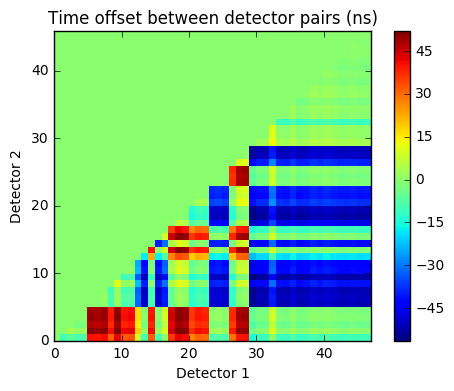

In [75]:
plt.pcolormesh(chList,chList[:-1],timeOffsetData)
plt.xlabel('Detector 1')
plt.ylabel('Detector 2')
plt.title('Time offset between detector pairs (ns)')
plt.xlim([0,47])
plt.ylim([0,46])
plt.colorbar()
plt.axes().set_aspect('equal')
plt.show()

The syntax for calling a value from `timeOffsetData` is:

    timeOffsetData[d1][d2]
    
where `d1` is the first detector channel number and `d2` is the second detector channel number. In all cases, `d1` must be less than `d2`. The indices where `d1` is greater than `d2` are empty in `timeDataOffset`. 

Now I need to look at Matthew's `crossCorr_v4.py` script and see how he implements `timeOffsetData`. The lines where he implements it are lines 147-152:

            if jDetIndex < iDetIndex: 
                timeOffset = -float(timeOffsetList[int(ccEvent['detector'][j])][int(ccEvent['detector'][i])])
            else:
                timeOffset = -float(timeOffsetList[int(ccEvent['detector'][i])][int(ccEvent['detector'][j])])
            
            dT = float(ccEvent['time'][i]) - float(ccEvent['time'][j]) + timeOffset
            
I would like to make my implementation simpler. Matthew calculates a negative time offset, then adds that. But what makes it the most difficult to read is the indexing... rather than just a `d1` or `d2` number, Matthew uses `int(ccEvent['detector'][j])` which is very lengthy.

Look back at how I calculate `dt`. Is it possible to call the time offset values for all detectors at once?

I have the detector channels that triggered in a vector, and their corresponding fission chamber channels. Can I call them together?

In [76]:
print(dets_present)
print(fc_corr)

print(timeOffsetData[0][15])
print(timeOffsetData[fc_corr[0]][dets_present[0]])

[22 30 43]
[16 16 32]
-8.6141215
30.010797


It looks like I can't call two indices at once by just calling `timeOffsetData[fc_corr][dets_present]`. Instead I need to create a new array of time offset values for the detectors involved in the interaction. Build it into the code I developed above `(indicated by #(TARGET)`).

In [77]:
for l, e in enumerate(data[:100]['event']):
    # print("Reading line: ",l,"; event: ",e)
    
    if e == eventNum: # Still on the same event
        pass          # Don't do anything.... but hold this here in case I want to add something
    
    if e != eventNum: # Store info from current event, move onto next event.
        j = l       # The last index of eventNum is the previous line
        n_ints = j-i # Number interactions in current event
        
        if n_ints > 2: # If there are more than 2 interactions in the event
            ccedEvent = data[i:j][:] # Pull out the data from this event
            chs_present = ccedEvent[:]['detector'] # What channels triggered?            
            chs_bool = np.in1d(chs_present,detList) # True = detector, False = fission chamber
            
            if sum(chs_bool)>1: # If at least two interactions were detectors / two or more Trues
                # Did the corresponding fc's trigger?
                dets_present = chs_present[chs_bool] # Which det channels triggered?
            
                fc_corr = 16*np.floor(dets_present/16) # Corresponding fission chambers for each det channel
                fc_corr = fc_corr.astype(int) # Convert to int
                fc_bool = np.in1d(fc_corr,chs_present) # Did the corresponding fission chamber trigger?
                
                if sum(fc_bool)>1: # If at least two detectors had corresponding fc triggers
                    print('bicorrelation!')
                    print(ccedEvent)
                    
                    # Only keep events where det and corresponding fc triggered (fc_bool = True)
                    dets_present = dets_present[fc_bool]
                    fc_corr      = fc_corr[fc_bool]                    
                    
                    det_indices = np.zeros(len(dets_present),dtype=np.int8) # What channels in chs_present correspond to these det chs
                    fc_indices  = np.zeros(len(fc_corr),dtype=np.int8) # What channels in chs_present are the corresponding fc are these det chs
                    time_offset = np.zeros(len(dets_present),dtype=np.float64) #(TARGET)
                    for d in range(0,len(dets_present),1):
                        det_indices[d] = np.where(chs_present == dets_present[d])[0]
                        fc_indices[d]  = np.where(chs_present == fc_corr[d])[0]
                        time_offset[d] = timeOffsetData[fc_corr[d]][dets_present[d]]  #(TARGET)
                        
                    print('det_indices',det_indices)
                    print('fc_indices',fc_indices)
                    
                    # Store dt and particle type for each detector event
                    dt       = np.zeros(len(dets_present),dtype=np.int8)
                    par_type = np.zeros(len(dets_present),dtype=np.int8)
                    
                    # Correct for time offset
                    dt       = ccedEvent[det_indices]['time']-ccedEvent[fc_indices]['time']+time_offset
                    print('dt',dt)
                    par_type = ccedEvent[det_indices]['particle_type']
                    print('par_type',par_type)  # par_type 1=n, 2=p
        
        eventNum = e  # Move on to next event
        i = l         # Current line is the first line for next event

bicorrelation!
[(16, 16, 2, 56.83219909667969, 1.0, 0.4312700033187866)
 (16, 22, 2, 26.677501678466797, 0.8963900208473206, 0.13186000287532806)
 (16, 30, 2, -75.39820098876953, 0.6321300268173218, 0.07415000349283218)
 (16, 32, 2, 57.012699127197266, 1.0, 0.43167001008987427)
 (16, 43, 2, 79.0250015258789, 0.2817400097846985, 0.05237000063061714)]
det_indices [1 2 4]
fc_indices [0 0 3]
dt [  -0.14390042 -143.50948809   11.6941294 ]
par_type [2 2 2]
bicorrelation!
[(44, 16, 2, 56.16529846191406, 1.0, 0.4361000061035156)
 (44, 29, 1, 111.27939987182617, 2.1337499618530273, 0.23030999302864075)
 (44, 32, 2, 56.51639938354492, 1.0, 0.4403199851512909)
 (44, 37, 1, 113.06719970703125, 1.0750700235366821, 0.10875999927520752)]
det_indices [1 3]
fc_indices [0 2]
dt [ 40.87007441  46.09551632]
par_type [1 1]


Check that the time offset worked. Look at event 16.

Without time offset correction:
```
ccedEvent:
[(16, 16, 2, 56.83219909667969, 1.0, 0.4312700033187866)
 (16, 22, 2, 26.677501678466797, 0.8963900208473206, 0.13186000287532806)
 (16, 30, 2, -75.39820098876953, 0.6321300268173218, 0.07415000349283218)
 (16, 32, 2, 57.012699127197266, 1.0, 0.43167001008987427)
 (16, 43, 2, 79.0250015258789, 0.2817400097846985, 0.05237000063061714)]
chs_present: [16 22 30 32 43]
dets_present: [22 30 43]
fc_corr: [16 16 32]
det_indices [1 2 4]
fc_indices [0 0 3]
dt [ -30.15469742 -132.23040009   22.0123024 ]
par_type [2 2 2]
```

With time offset correction:
```
ccedEvent:
[(16, 16, 2, 56.83219909667969, 1.0, 0.4312700033187866)
 (16, 22, 2, 26.677501678466797, 0.8963900208473206, 0.13186000287532806)
 (16, 30, 2, -75.39820098876953, 0.6321300268173218, 0.07415000349283218)
 (16, 32, 2, 57.012699127197266, 1.0, 0.43167001008987427)
 (16, 43, 2, 79.0250015258789, 0.2817400097846985, 0.05237000063061714)]
chs_present: [16 22 30 32 43]
dets_present: [22 30 43]
fc_corr: [16 16 32]
det_indices [1 2 4]
fc_indices [0 0 3]
dt [ -60.16549442 -120.95131209   32.3304754 ]
par_type [2 2 2]
```

The first detector is channel 22. What is the time offset between that channel and the corresponding fission chamber on channel 16?

In [78]:
print(timeOffsetData[16][22])

30.010797


The difference in `dt` with and without the time offset correction is adjusted by that amount, so call it correct. The question remains, should I be adding or subtracting the time offset? At first I was subtracting the `time_offset`, but the $\gamma\gamma$ distribution was not centered at (0,0), so I changed it to adding.

# Step 6: Write out each bicorrelation event to a text file called `bicorr`. 

Practice writing out variables to a text file. What information do I want to store from the bicorrelation event?

* col 1) Event number
* col 2) Det 1 CH
* col 3) Det 1 particle type
* col 4) Det 1 $\Delta t_1$
* col 5) Det 2 CH
* col 6) Det 2 particle type
* col 7) Det 2 $\Delta t_2$

In [86]:
# Open a text file to write to
printFile = open('../datar/1/bicorr1','w')

print(ccedEvent[0]['event'])
print(dt)
print(dets_present)
print(par_type)

d1 = 0
d2 = 1
printFile.write(str(ccedEvent[0]['event']) + '  ' + str(dets_present[d1]) + '  ' + str(par_type[d1]) + '  ' + str(dt[d1]) 
                                           + '  ' + str(dets_present[d2]) + '  ' + str(par_type[d2]) + '  ' + str(dt[d2]))
printFile.close()


4360
[ -78.15717977 -125.34806059]
[15 40]
[1 2]


Print the contents of the file I just generated here:

In [87]:
with open('../datar/1/bicorr1') as f: # The with keyword automatically closes the file when you are done
    print(f.read())

4360  15  1  -78.1571797695  40  2  -125.34806059


Now insert this into the loop.

In [88]:
# Open a text file to write to
printFile = open('../datar/1/bicorr1','w')

# Identify whether each event was a bicorrelation event by looking at the number of interactions and the channel numbers
chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists(print_flag = True)

# l is the line number of the current line, starting at 0.
# e is the event number of the current line, starting at 1

# eventNum is the current event number. From lines i to j.
eventNum = data[0]['event']; # Start with the first event in the data chunk.
                             # If reading entire file, this is 1. If reading a chunk, this may be higher
i        = 0;                # First line number of first event is always 0

for l, e in enumerate(data[:]['event']):
    if e == eventNum: # Still on the same event
        pass          
    
    if e != eventNum:                                  # Store info from current event, move onto next event.
        j = l                                          # The last index of eventNum is the previous line
        n_ints = j-i                                   # Number interactions in current event
        
        if n_ints > 2:                                 # If > 2 interactions in the event
            ccedEvent = data[i:j][:]                   # Pull out the data from this event
            chs_present = ccedEvent[:]['detector']     # What channels triggered?
            chs_bool = np.in1d(chs_present,detList)    # True = detector, False = fission chamber
            
            if sum(chs_bool)>1:                        # If >2 detectors, did corr fc's trigger?
                dets_present = chs_present[chs_bool]   # Which det channels triggered?
                
                fc_corr = (16*np.floor(dets_present/16)).astype(int) # Corr fc for each det ch

                fc_bool = np.in1d(fc_corr,chs_present) # Did the corresponding fission chamber trigger?
                
                if sum(fc_bool)>1:                     # If >2 det + corr fc, keep those
                    dets_present = dets_present[fc_bool]
                    fc_corr      = fc_corr[fc_bool]                    
                    
                    det_indices = np.zeros(len(dets_present),dtype=np.int8)    # Where does chs_present = these det chs?
                    fc_indices  = np.zeros(len(fc_corr),dtype=np.int8)         # Where does chs_present = these fc chs?
                    time_offset = np.zeros(len(dets_present),dtype=np.float64) # Store time offset
                    
                    for d in range(0,len(dets_present),1):
                        det_indices[d] = np.where(chs_present == dets_present[d])[0]
                        fc_indices[d]  = np.where(chs_present == fc_corr[d])[0]
                        time_offset[d] = timeOffsetData[fc_corr[d]][dets_present[d]]
                    
                    # Store dt and particle type for each detector event
                    dt       = np.zeros(len(dets_present),dtype=np.int8)
                    par_type = np.zeros(len(dets_present),dtype=np.int8)
                    
                    # Correct for time offset
                    dt       = ccedEvent[det_indices]['time']-ccedEvent[fc_indices]['time']-time_offset
                    par_type = ccedEvent[det_indices]['particle_type']
                    
                    # Write out event info from all detector pairs
                    for d1 in range(0,len(det_indices)-1,1):
                        for d2 in range(d1+1,len(det_indices),1):
                            printFile.write(str(ccedEvent[0]['event'])
                                            + '  ' + str(dets_present[d1]) + '  ' + str(par_type[d1]) + '  ' + str(dt[d1]) 
                                            + '  ' + str(dets_present[d2]) + '  ' + str(par_type[d2]) + '  ' + str(dt[d2])
                                            + '\n')
        
        eventNum = e  # Move on to next event
        i = l         # Current line is the first line for next event
        
        
printFile.close()

Fission chamber channels: [ 0 16 32]
Detector channels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Number of detectors: 45
Number of detector pairs: 990


The `bicorr` file that was produced has multiple lines for some events:

```
16  22  2  -30.1546974182  30  2  -132.230400085
16  22  2  -30.1546974182  43  2  22.0123023987
16  30  2  -132.230400085  43  2  22.0123023987
44  29  1  55.1141014099  37  1  56.5508003235
52  10  2  206.289699554  30  2  10.6130981445
76  10  2  -112.366802216  14  2  -34.8992996216
87  4  1  41.3330993652  38  2  7.32550048828
93  19  1  13.7381019592  20  2  -27.9251976013
98  7  2  -127.604602814  34  2  10.223400116
98  7  2  -127.604602814  37  2  -73.8257026672
98  34  2  10.223400116  37  2  -73.8257026672
99  22  2  187.418201447  26  2  185.284301758
```

This looks good. I need to try it on the cluster, and figure out how to run it in all of the subfolders. Functionalize it.

# Step 7: Read and write into multiple subfolders

So far I am just reading one file from folder 1. I need to read multiple `cced` files in different subfolders and write a `bicorr` file into each of those subfolders.

In [89]:
folders = np.arange(1,3,1)
print(folders)

[1 2]


In [90]:
cced_root = 'cced'
root_path = '../datar/'

for folder in folders:
    cced_open = os.path.join(root_path + '/' + str(folder)+'/'+cced_root+str(folder))
    
    print(folder)
    print(cced_open)
    
    data = np.genfromtxt(cced_open,dtype=ccedType)

1
../datar//1/cced1
2
../datar//2/cced2


I folded this into the `bicorr.py` script.

This produces a `bicorr` file in each folder. I would like to combine them into one giant `bicorr` file. Try it out.

In [93]:
folders = np.arange(1,3,1)#np.array([1,2])
print(folders)

with open('bicorr_all','w') as outfile:
    for folder in folders:
        bicorr_file = os.path.join(root_path + '/' + str(folder)+'/'+'bicorr'+str(folder))
        print('opening:',bicorr_file)
        with open(bicorr_file) as infile:
            for line in infile:
                outfile.write(line)
    


[1 2]
opening: ../datar//1/bicorr1
opening: ../datar//2/bicorr2


# Step 8: Put it all together

I combined all of these steps into a function called `generate_bicorr` in my `bicorr.py` module. View the contents of that function:

In [98]:
print(inspect.getsource(bicorr.generate_bicorr))

def generate_bicorr(folder_start=1,folder_end=2,root_path=None):
    """
	Parse cced files and produce bicorr output file in each folder from folder_start up to (not including) folder_end.     Developed in fnpc\analysis\2016_11_30_pfs_bicorrelation_plot\generate_bicorr_from_cced.ipynb
		
	Reads in cced file, format: event, detector, particle_type, time, integral, height
	Produces bicorr file, format: event, det1ch, det1par, det1t, det2ch, det2par, det2t
    
    Parameters
    ----------
    folder_start : int, optional
        First folder
    folder_end : int, optional
        Last folder + 1 (for example, folder_end = 2 will end at folder 1)
    root_path : int, optional
        Relative path to folder where data folders exist (1, 2, 3, etc.). default = cwd
    
    Returns
    ------- 
    n/a
	"""
    # If no data path provided, look for data folders here
    if root_path == None: root_path = os.getcwd()
    
    # Folders to run
    folders = np.arange(folder_start,folder_end,1)


In [101]:
bicorr.generate_bicorr(folder_start=1,folder_end=3,root_path='../datar')

Generating bicorr file for folders:  [1 2]
processing: 1
opening: ../datar/1/cced1
write to: <_io.TextIOWrapper name='../datar/1/bicorr1' mode='w' encoding='cp1252'>
processing: 2
opening: ../datar/2/cced2
write to: <_io.TextIOWrapper name='../datar/2/bicorr2' mode='w' encoding='cp1252'>


# Update: Add pulse height threshold

Matthew pointed out that I need to implement a pulse height threshold in my analysis. I had not included one, and he ran the dat with a very low pulse height threshold (40 keVee). I need to implement one at 100 keVee (a little conservative vs. 80 keVee but we will try it there first).

I am going to tack this on to the end of this notebook rather than rewriting the notebook. Let's see.

As a reminder, the format of the `cced` file is:

* 1) event number: `evnum`
* 2) channel number `chnum`
* 3) particle (1=n, 2=g) `part`
* 4) time, $ns$ `time`
* 5) PSD total integral `totint`
* 6) pulse height `height`

The pulse height column is already calibration to MeVee, so I can set a threshold on that column to 0.1. I need both neutrons to exceed 0.1 MeVee. 

I'm going to run it first without this energy threshold, and then run it with the energy threshold and see how things compare.